In [8]:
import numpy as np 
import pandas as pd 
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

In [12]:
train_transaction = pd.read_csv('./train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('./test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('./train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('./test_identity.csv', index_col='TransactionID')

# #load data
# train_identity = pd.read_csv('./train_identity.csv')
# train_transaction = pd.read_csv('./train_transaction.csv')
# test_identity = pd.read_csv('./test_identity.csv')
# test_transaction = pd.read_csv('./test_transaction.csv')
# sample_sub = pd.read_csv('./sample_submission.csv')

In [9]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [ ]:
# #combine into train and test dataset
# train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
# test = pd.merge(test_transaction, test_identity, on  = 'TransactionID', how = 'left')
# #left join identity to transaction because there are more rows in transaction

In [10]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  V330  V331  V332  V333  \
TransactionID                                    ...                           
2987000        150.0    discover  142.0  credit  ...   NaN   NaN   NaN   NaN   
2987001        150.0  mastercard  102.0  credit  ...   NaN   NaN   NaN   NaN   
2987002        150.0        visa  166.0   debit  ...   NaN   NaN   NaN   NaN   
2987003        150.0  mastercard  117.0   debit  ...   NaN   NaN   NaN   NaN   
2987004        150.0  mastercard  102.0  credit  ...   0.0   0.0   0.0   0.0   

              V334 V335  V336  V337  V338  V339  
TransactionID                                    
2987000        NaN  NaN   NaN   NaN   NaN   NaN  
2987001        NaN  NaN   NaN   NaN   NaN   NaN  
2987002        NaN  NaN   NaN   NaN   NaN   NaN  
2987003        NaN  NaN   NaN   NaN   NaN   NaN  
2987004        0.0  0.0   0.0   0.0   0.0   0.0  

[5 rows x 393 columns]

In [38]:
transaction_col = train_transaction.columns.get_values()
transaction_col

C:\Users\mcui1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.



array(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
       'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
       'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34',
       'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43',
       'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52',
       'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61',
       'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70',

In [11]:
train_identity.head()

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

               id_09  id_10  ...                id_31 id_32      id_33  \
TransactionID                ...                                         
2987004          NaN    NaN  ...  samsung browser 6.2  32.0  2220x1080   
2987008          NaN    NaN  ...   mobile safari 11.0  32.0   1334x750   
2987010          0.0    0.0  ...          chrome 62.0   NaN        NaN   
2987011          NaN    NaN  ...          chrome 62.0   NaN        NaN   
2987016          0.0    0.0  ...          chrome 62.0  24.0   1280x800   

                        id_34 id_35 id_36  id_37  id_38  DeviceType  \
TransactionID                                                         
2987004        match_status:2     T     F      T      T      mobile   
2987008        match_status:1     T     F      F      T      mobile   
2987010                   NaN     F     F      T      T     desktop   
2987011                   NaN     F     F      T      T     desktop   
2987016        match_status:2     T     F      T      T     desktop   

                                  DeviceInfo  
TransactionID                                 
2987004        SAMSUNG SM-G892A Build/NRD90M  
2987008                           iOS Device  
2987010                              Windows  
2987011                                  NaN  
2987016                                MacOS  

[5 rows x 40 columns]

In [40]:
identity_col = train_identity.columns.get_values()
identity_col

C:\Users\mcui1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.



array(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07',
       'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
       'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28',
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype=object)

#### Problem 1: Lots of NAs 

- Train_transaction ... lots of missing values 

In [14]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:20])

total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
dtype: int64
% of missing data =  41.17794374769424


- Train_identity ... lots of missing values 

In [15]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


#### Problem 2: Imbalanced classes

- Most of the transactions are NOT fraud
- If we use this df as base for prediction, then we are going to overfit b/c it assumes most transactions are NOT fraud.
- Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading
- https://www.kaggle.com/shahules/tackling-class-imbalance made a good point:

"I don't understand why the competition hosts selected ROC_AUC as evaluation metric,I think ROC curves should be used when there are roughly equal numbers of observations for each class. Precision-Recall curves should be used when there is a moderate to large class imbalance."

- Can use resampling skill introduced in this post to deal with this issue 
- Also, suggest we do AUC as well as PR curve

- Smote -> imbalance
- F1 score

In [22]:
fraudcount = train_transaction['isFraud'].value_counts()
fraudcount

0    569877
1     20663
Name: isFraud, dtype: int64

In [36]:
print('  {:.4f}% of Transactions that are fraud in train '.format(train_transaction['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


#### Problem 3: Not all transactions have corresponding identity information.

In [23]:
print(np.sum(train_transaction.index.isin(train_identity.index.unique())))
print(np.sum(test_transaction.index.isin(test_identity.index.unique())))

144233
141907


In [31]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)


Essentially:
- 24.4% of TransactionIDs in train (144233 / 590540) have an associated train_identity.
- 28.0% of TransactionIDs in test (141907 / 506691) have an associated train_identity.

#### Problem 4: What is TransactionDT?

- The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
- Online posts state that TransactionDT column is measured in seconds, starting at December 1.
- TransactionDT is not a timestamp, but somehow we use it to measure time.
- https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

In [18]:
print(train_transaction['TransactionDT'].min())
print(train_transaction['TransactionDT'].max())

print(test_transaction['TransactionDT'].min())
print(test_transaction['TransactionDT'].max())

86400
15811131
18403224
34214345


In [25]:
print(test_transaction['TransactionDT'].max() - train_transaction['TransactionDT'].min())
print((test_transaction['TransactionDT'].max() - train_transaction['TransactionDT'].min())/(3600*24*365))

# makes sense that this is in seconds, so the total time span is around 1 year 

34127945
1.0821900367833588


In [23]:
(train_transaction['TransactionDT'].max()) - (train_transaction['TransactionDT'].min())

15724731

In [32]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

- Observation: train and test transaction dates don't overlap
- It would be prudent to use time-based split for validation

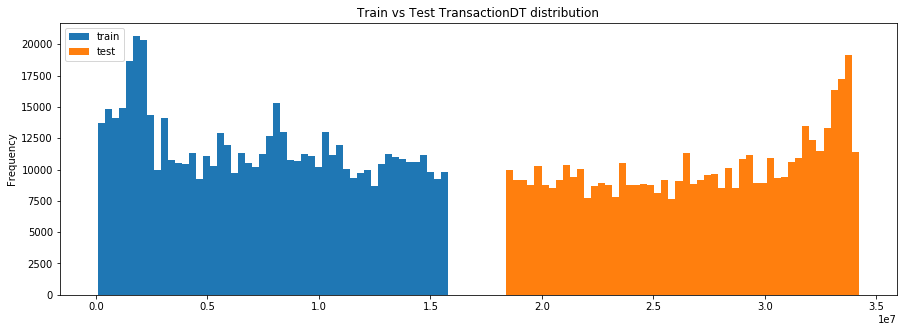

In [33]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

### Conclusion: 
- Data is split into train and test set, time series wise.
- There is a slight gap inbetween. The training set is from an earlier period of time, test is from a later period of time.

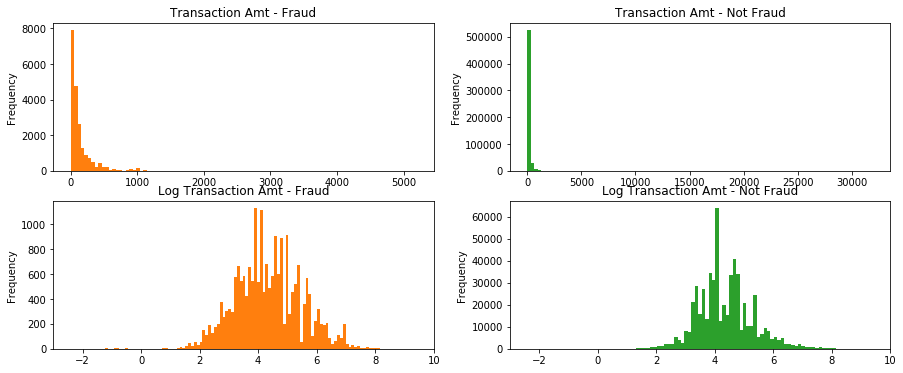

In [29]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))

train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax1)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax2)

train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax3)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax4)

plt.show()


In [33]:
print('Mean transaction amt for fraud in train is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud in train is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud in train is 149.2448
Mean transaction amt for non-fraud in train is 134.5117


# dist 1 & dist 2

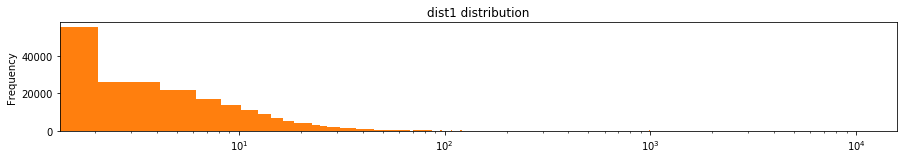

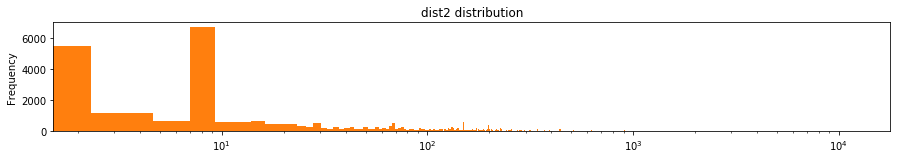

In [34]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()


Possibly this could be the distance of the transaction vs. the card owner's home/work address. This is just a guess.

# C1 - C14

In [35]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
TransactionID                                                               
2987000        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
2987001        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2987002        1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987003        2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
2987004        1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

                C13  C14  
TransactionID             
2987000         1.0  1.0  
2987001         1.0  1.0  
2987002         1.0  1.0  
2987003        25.0  1.0  
2987004         1.0  1.0

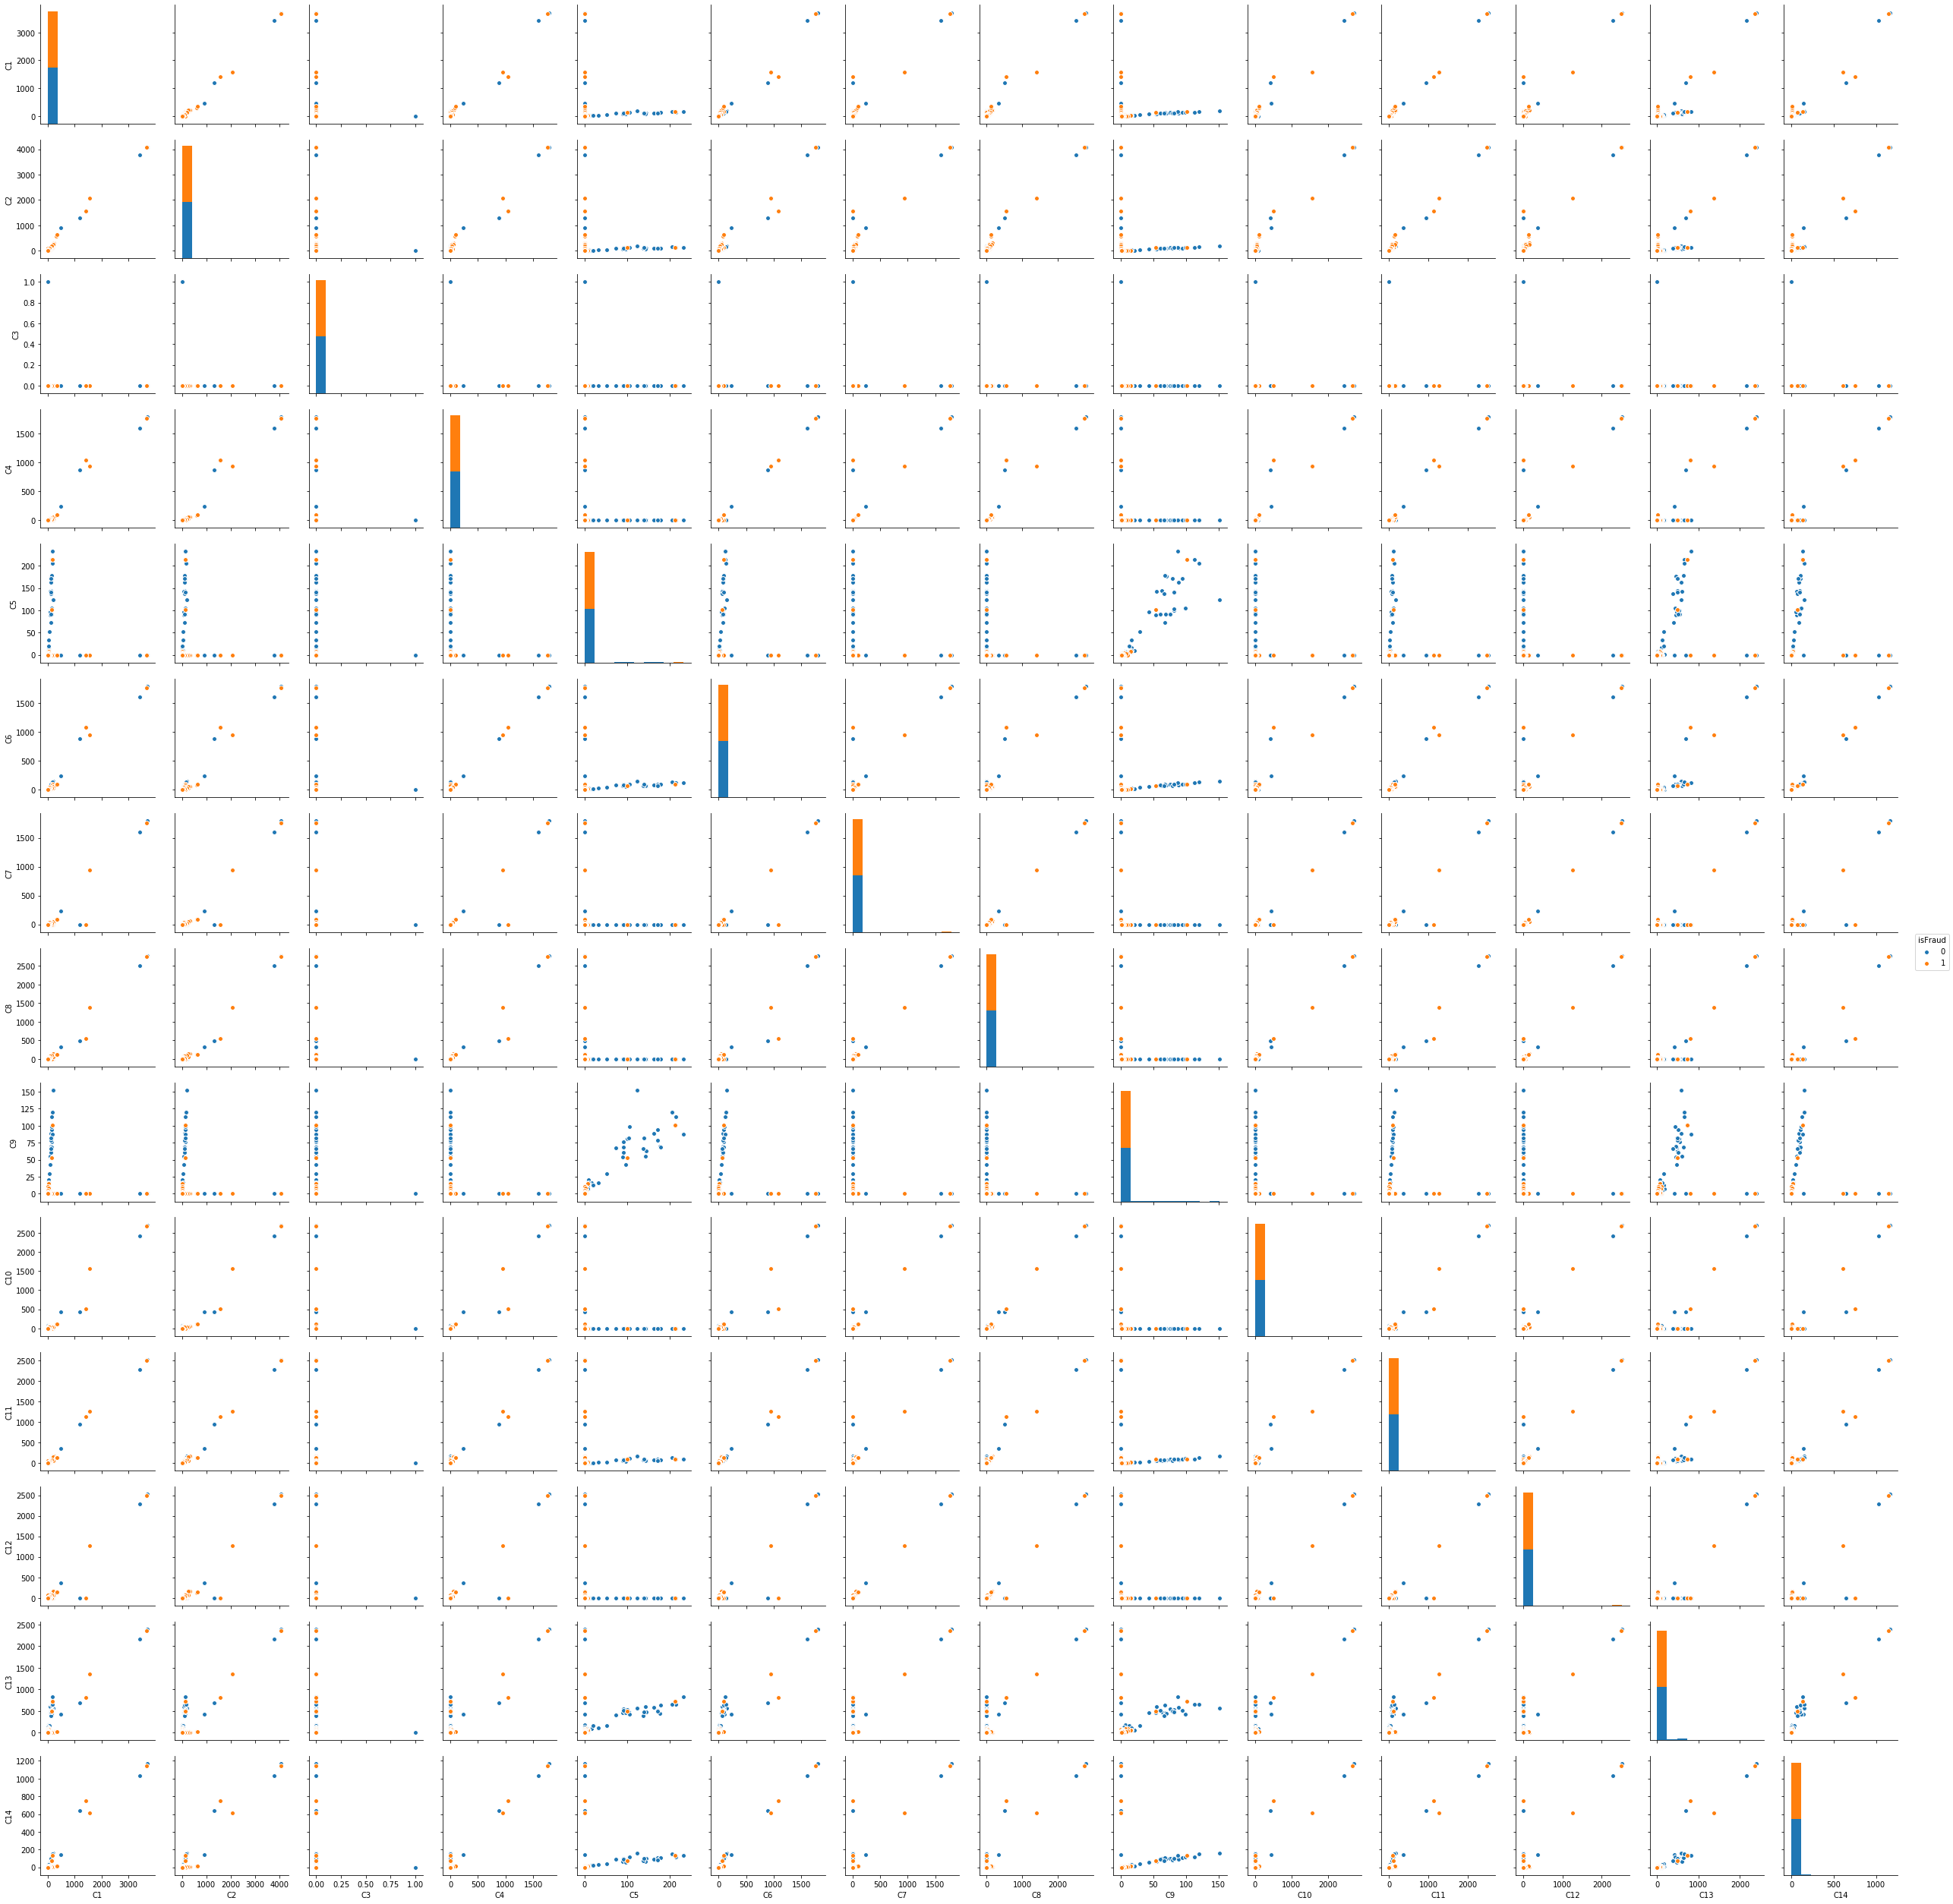

In [36]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

### Plotting features over time (C1 - C14) : 

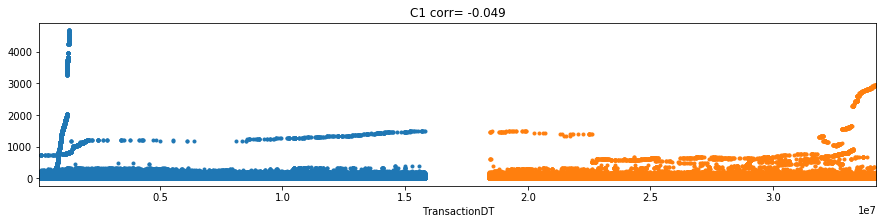

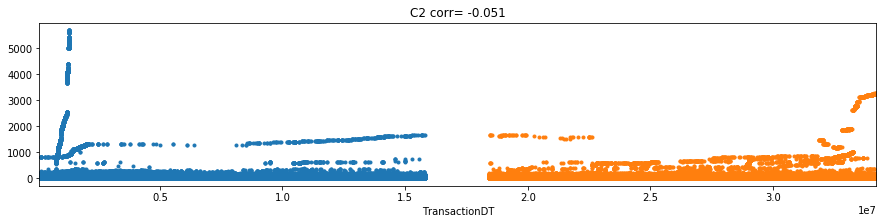

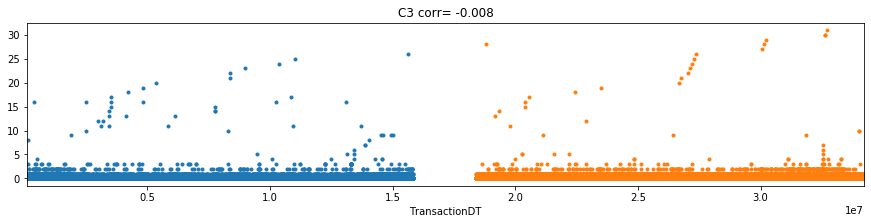

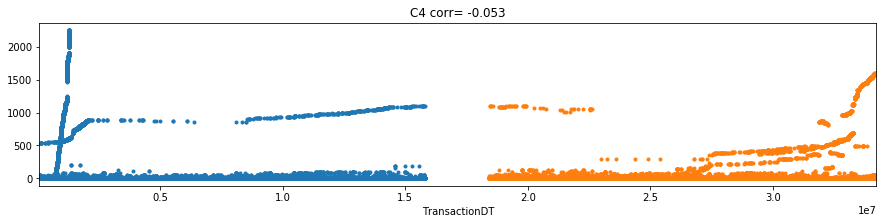

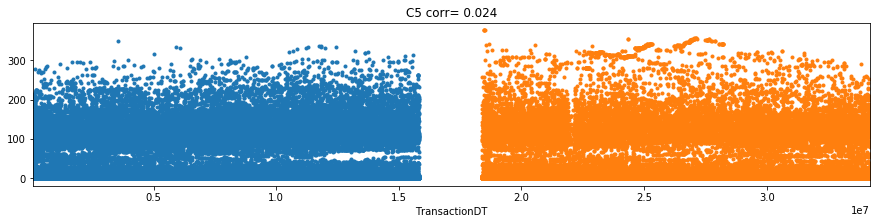

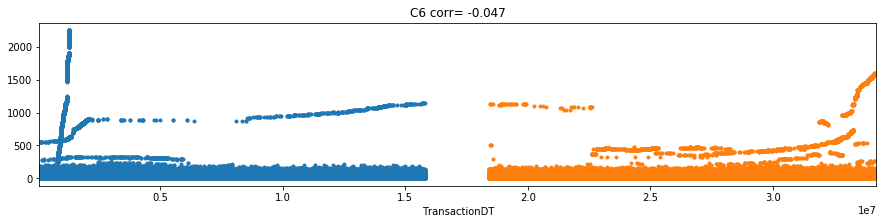

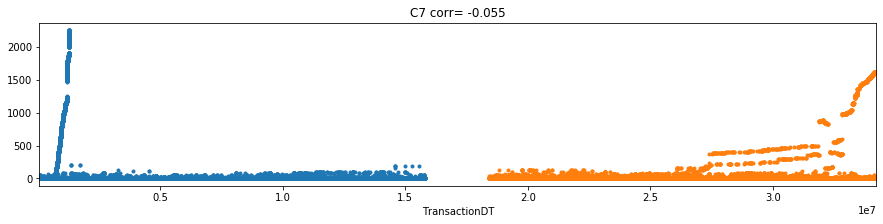

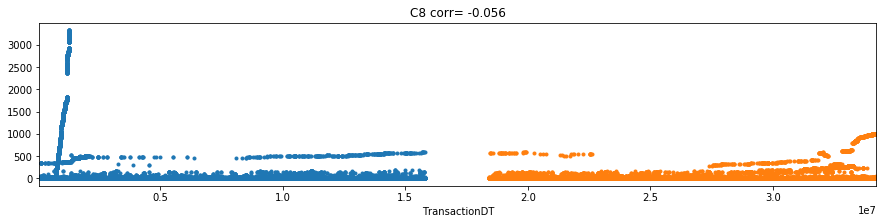

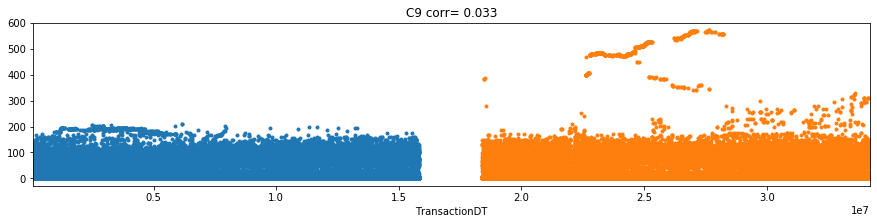

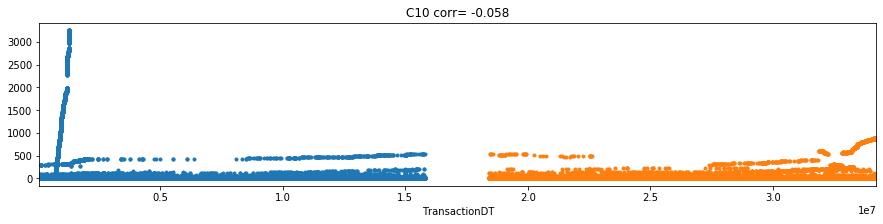

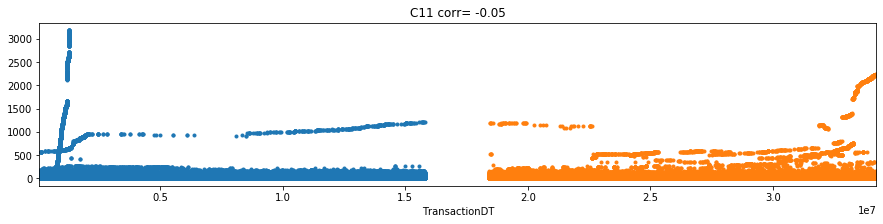

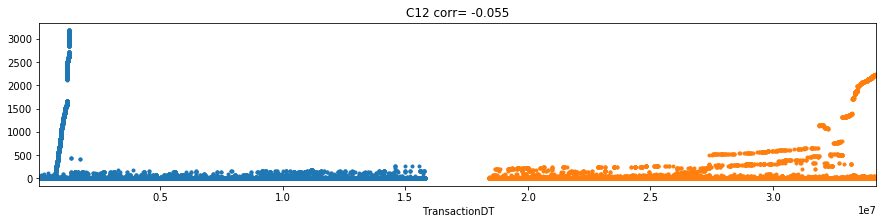

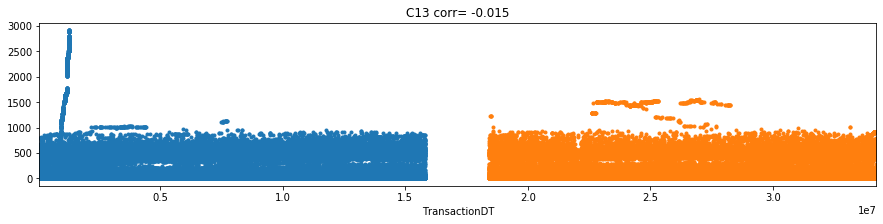

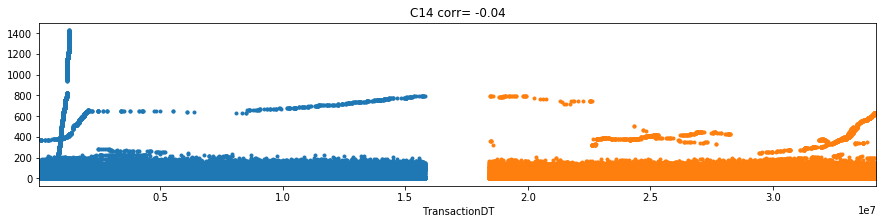

In [48]:
c_features = list(train_transaction.columns[16:30])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

#### Number of unique valued per feature (C, train)

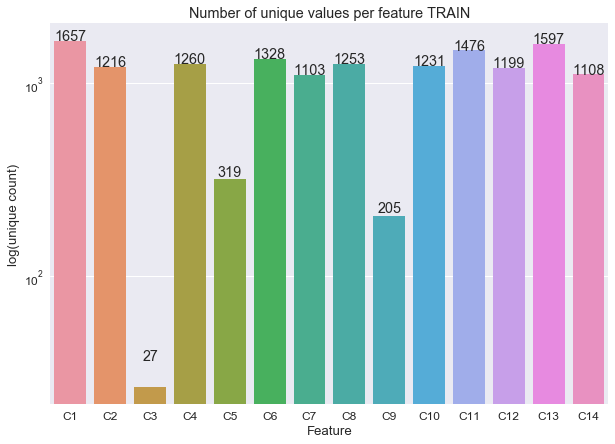

In [53]:
plt.figure(figsize=(10, 7))
c_features = list(train_transaction.columns[16:30])
uniques = [len(train_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

#### Number of unique valued per feature (C, test)

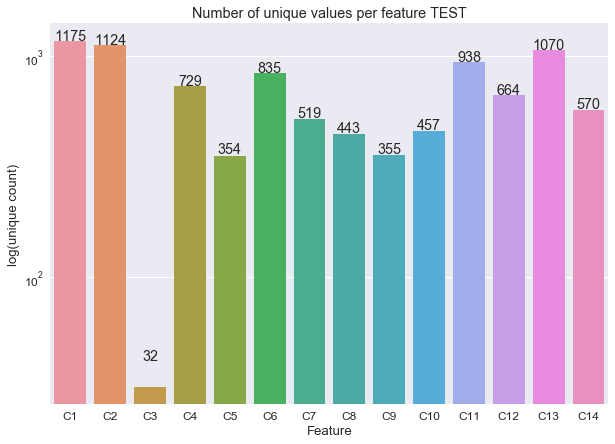

In [57]:
plt.figure(figsize=(10, 7))
c_features = list(test_transaction.columns[15:29])
uniques = [len(test_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

# D1 - D15

#### The problem here is that D features are mostly NaNs!

In [37]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  \
TransactionID                                                               
2987000         14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0   
2987001          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN   
2987002          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0   
2987003        112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN   
2987004          0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN   

               D12  D13  D14    D15  
TransactionID                        
2987000        NaN  NaN  NaN    0.0  
2987001        NaN  NaN  NaN    0.0  
2987002        NaN  NaN  NaN  315.0  
2987003        NaN  NaN  NaN  111.0  
2987004        NaN  NaN  NaN    NaN

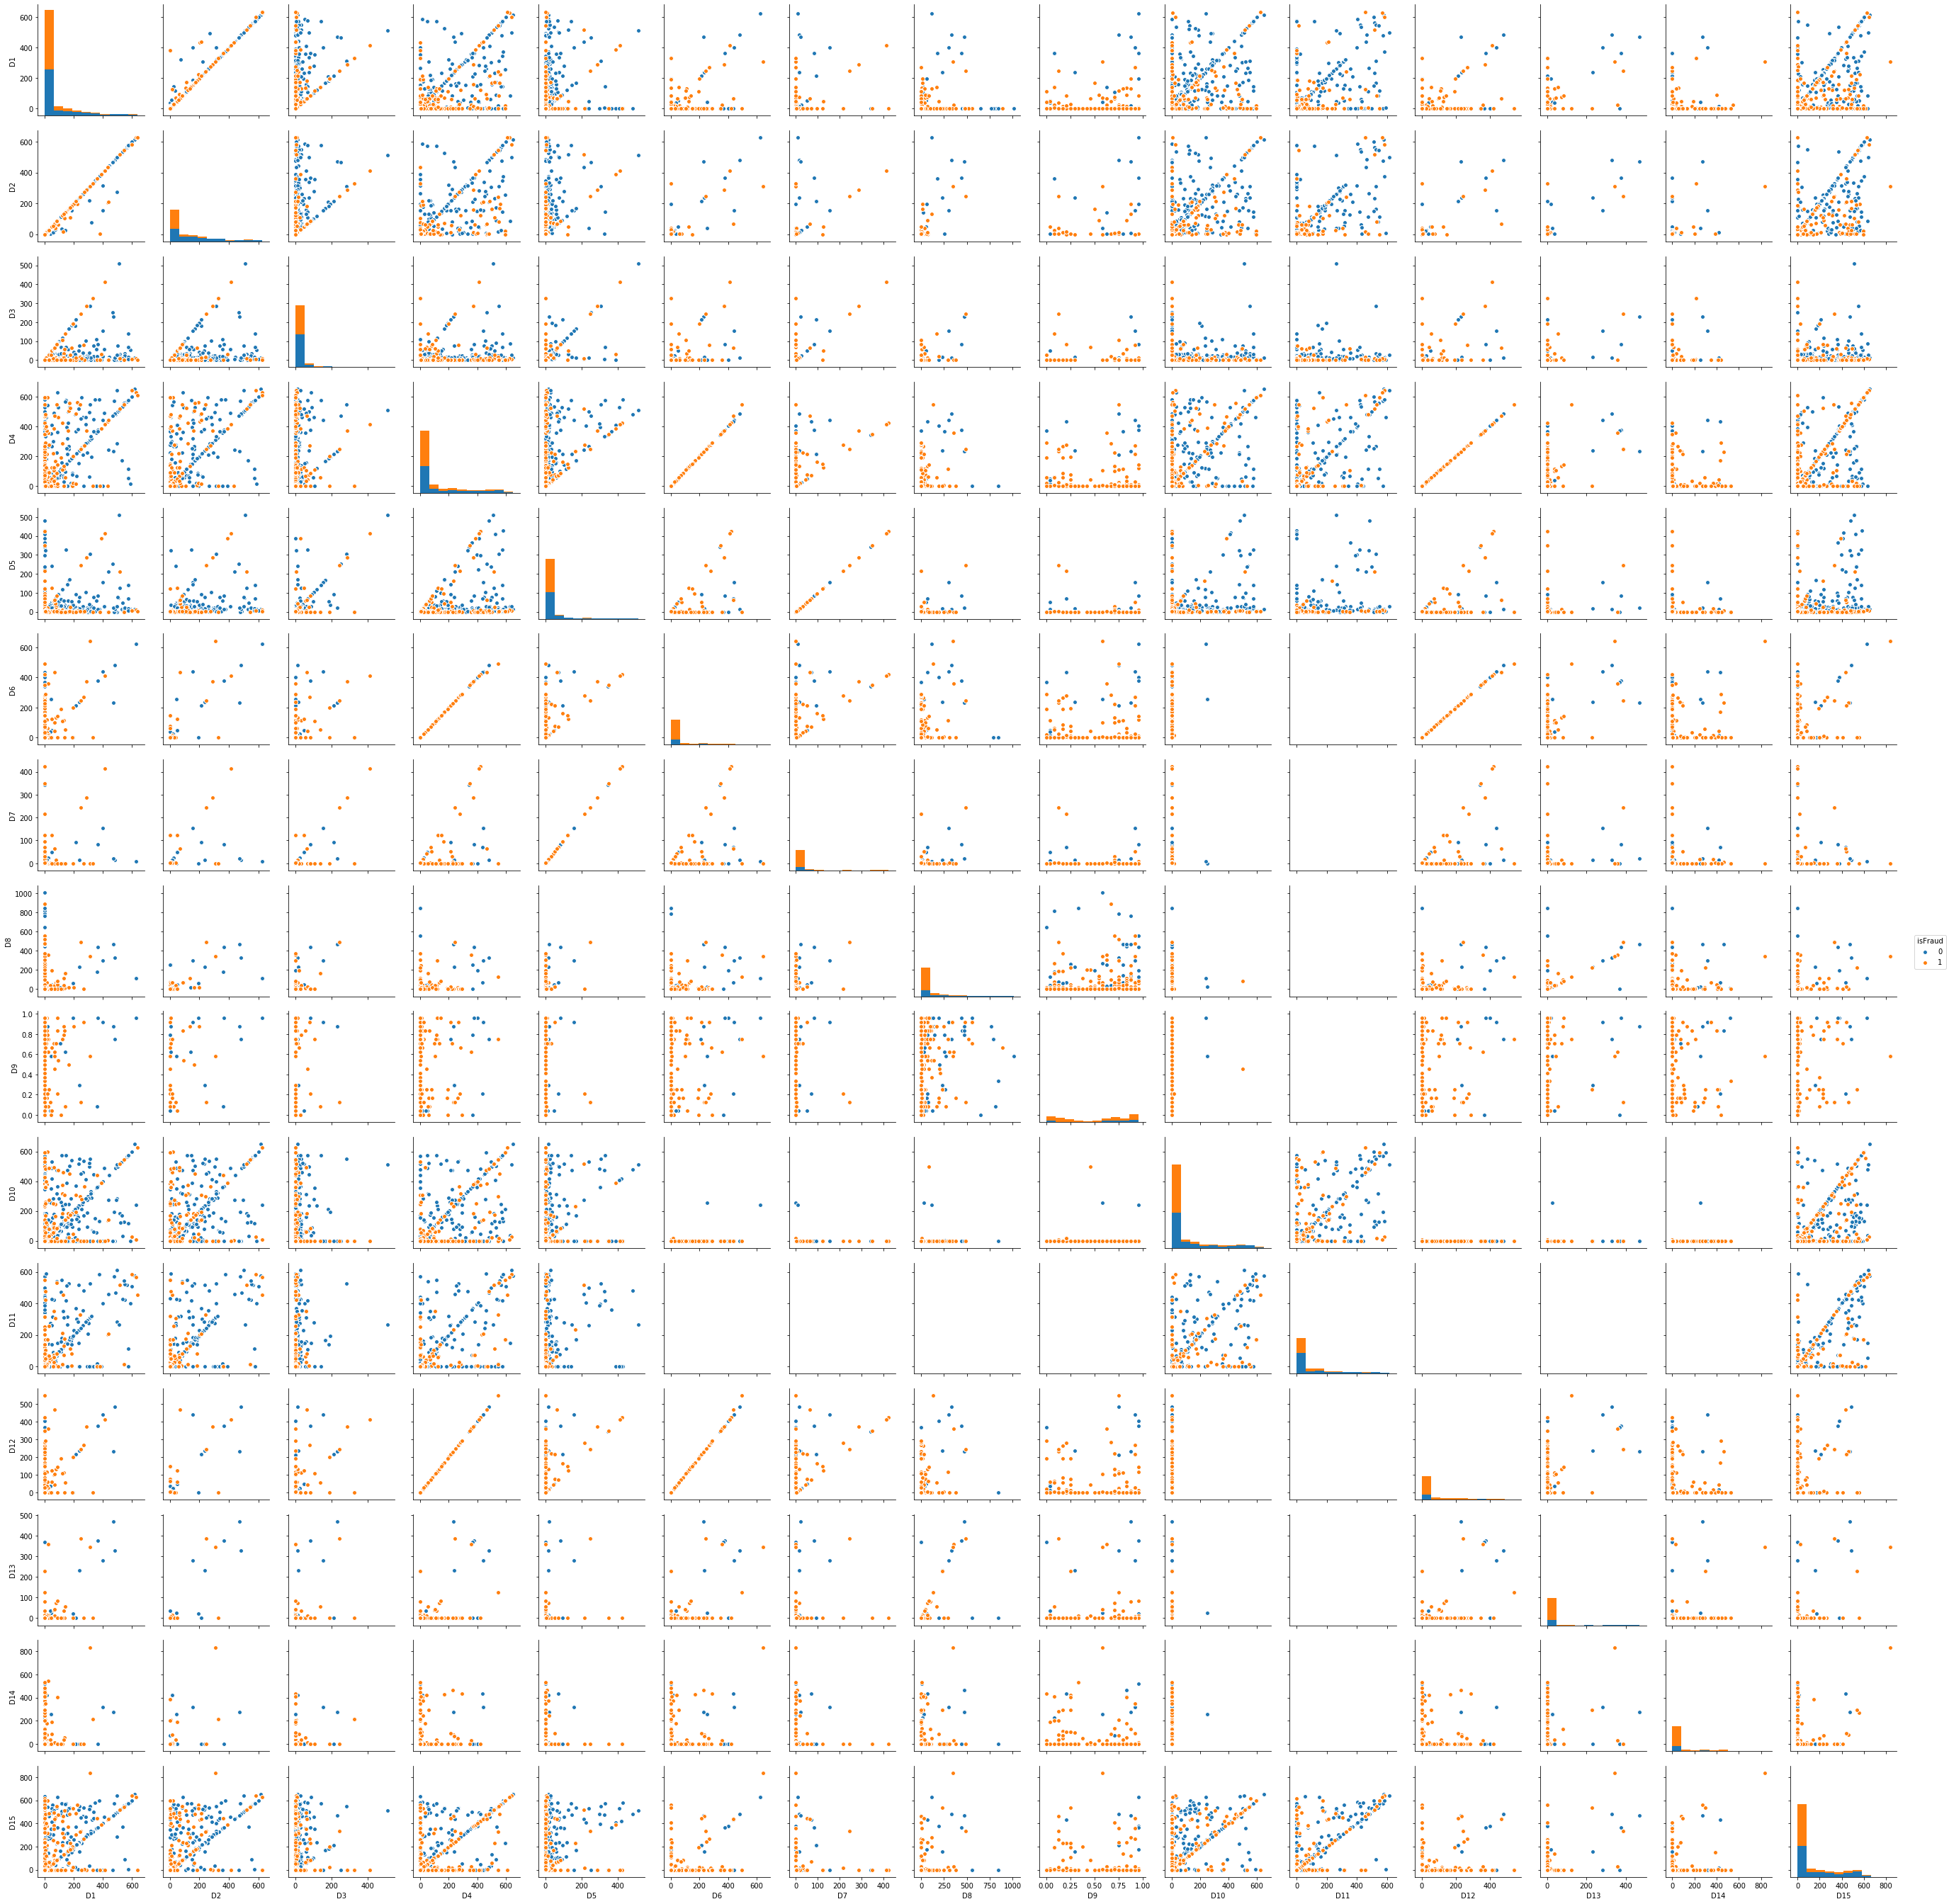

In [38]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

### Plotting features over time (D1 - D15) : 

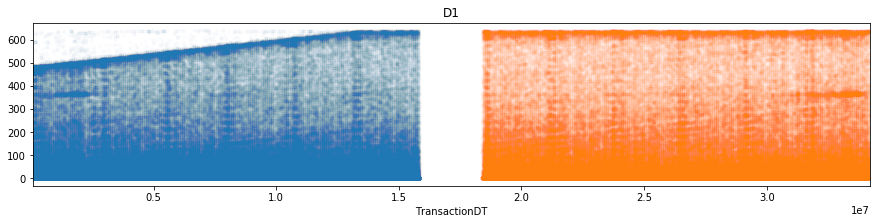

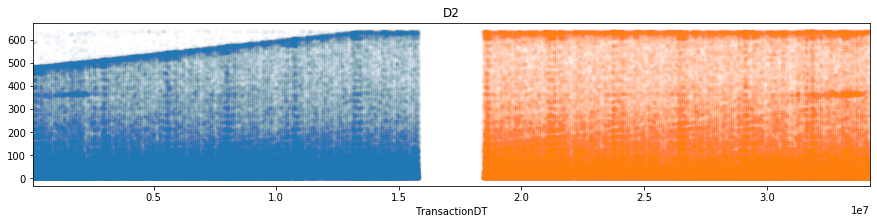

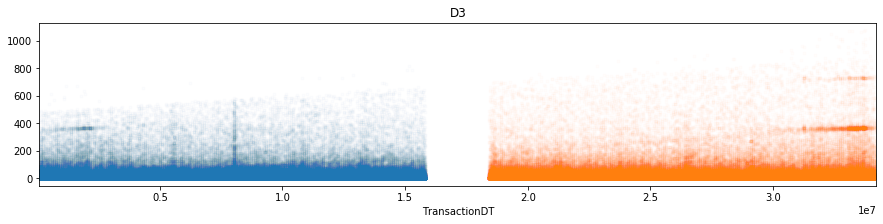

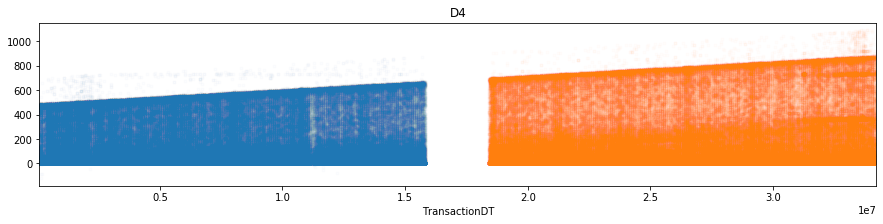

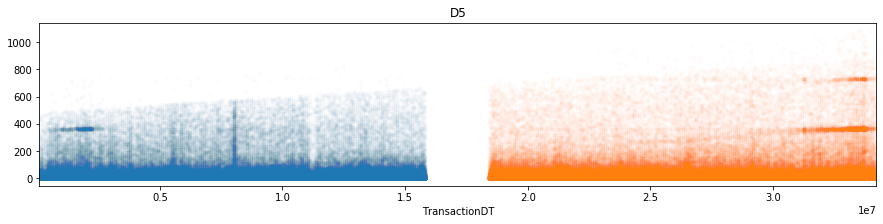

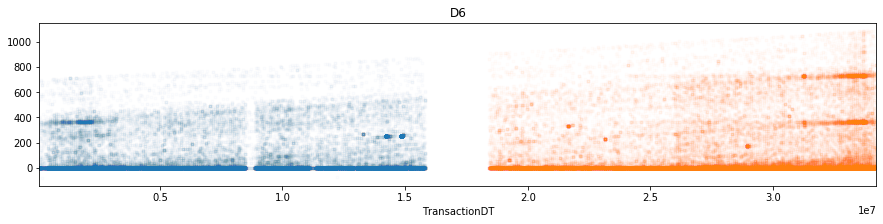

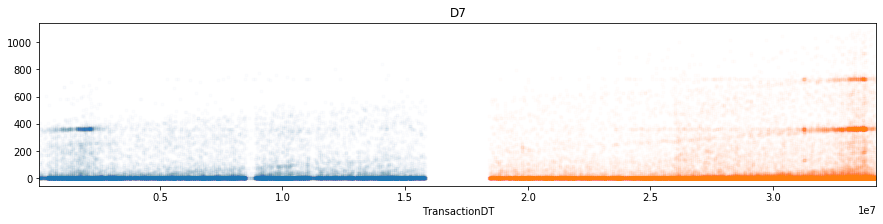

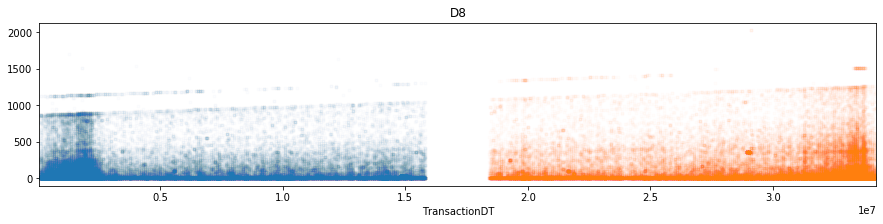

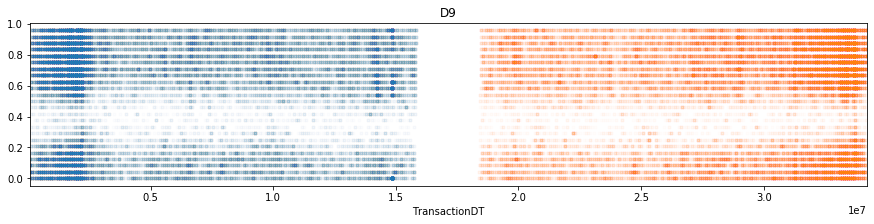

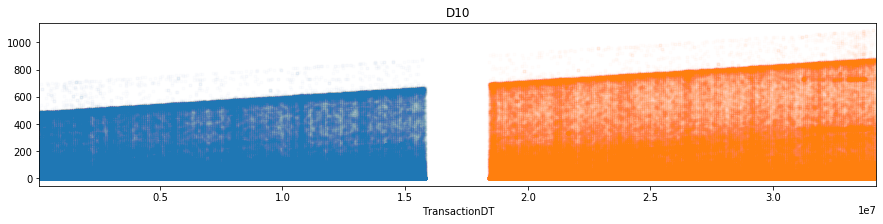

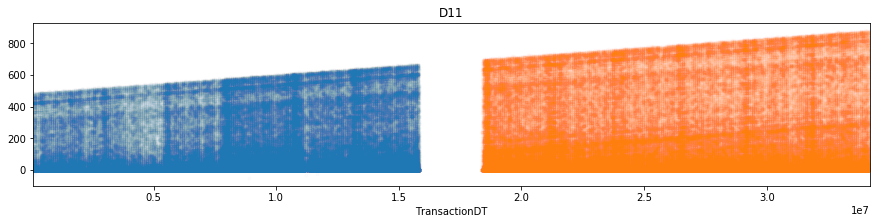

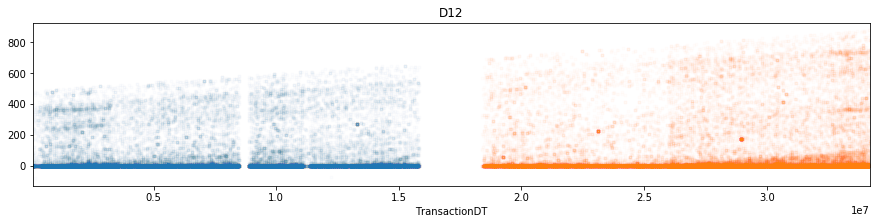

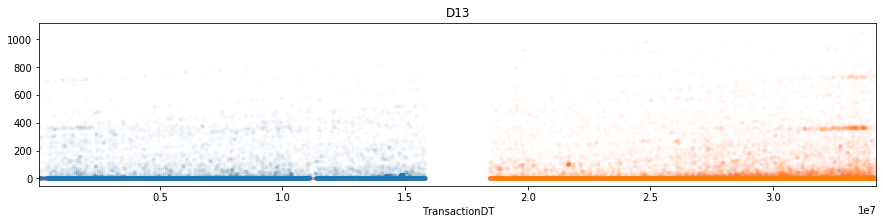

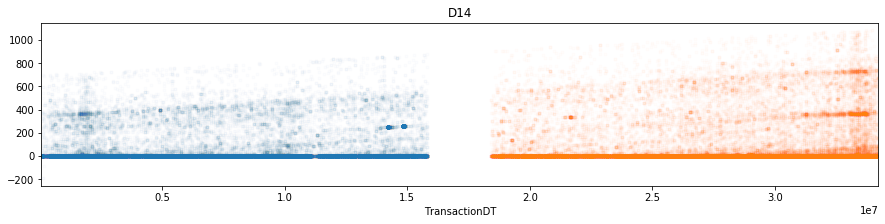

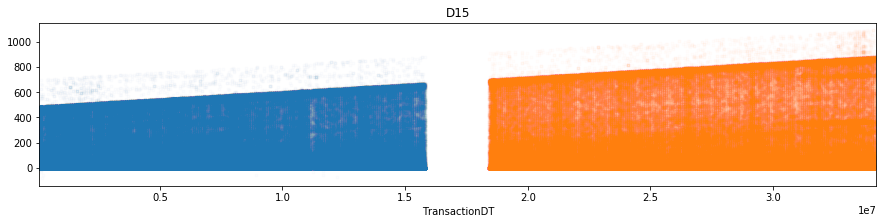

In [51]:
for c in ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass
    
# D9 is very interesting 

#### Number of unique valued per feature (D, train)

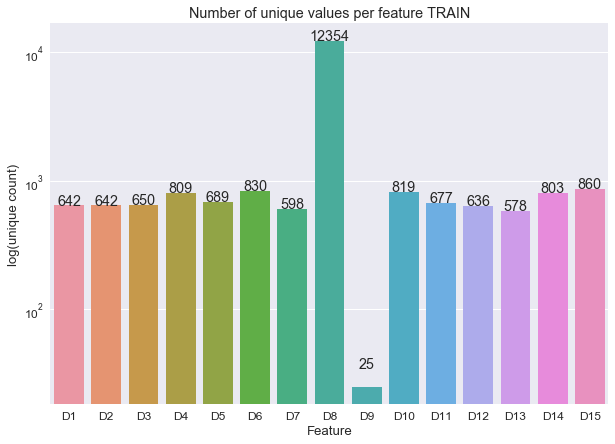

In [55]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

#### Number of unique valued per feature (D, test)

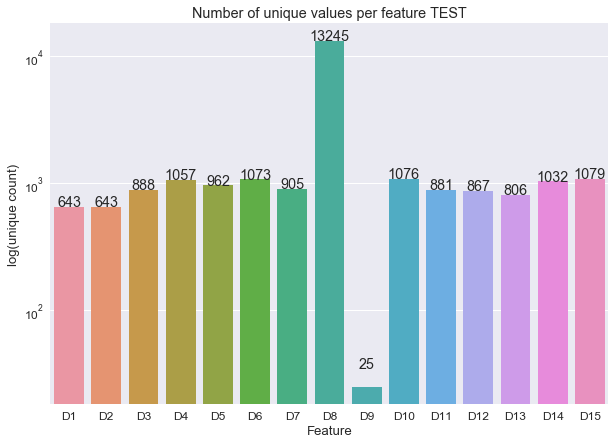

In [58]:
plt.figure(figsize=(10, 7))
d_features = list(test_transaction.columns[29:44])
uniques = [len(test_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

# V1 - V339

In [39]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  \
TransactionID                                                    ...         
2987000        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   
2987001        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
2987002        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   
2987003        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   

               V331  V332  V333  V334  V335  V336  V337  V338  V339  
TransactionID                                                        
2987000         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2987001         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2987002         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2987003         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2987004         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [40]:
train_transaction[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741883   
std         0.226339       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

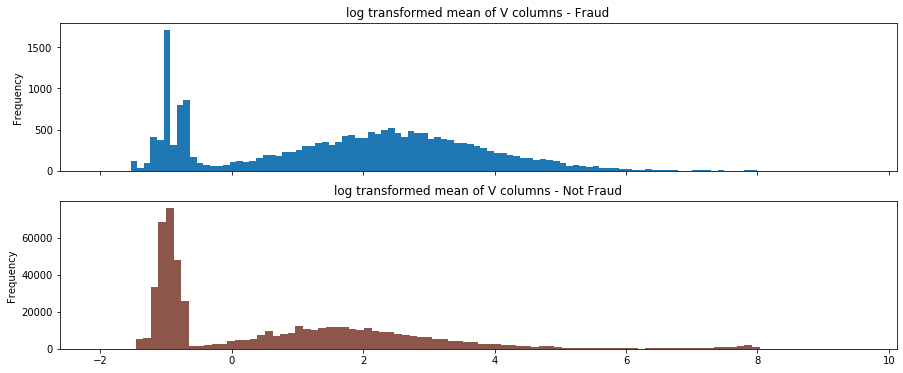

In [41]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

### Plotting features over time (selected V features) :

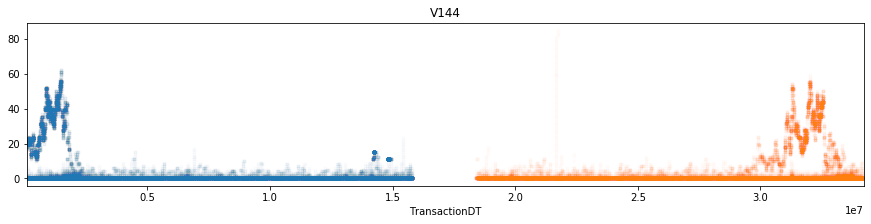

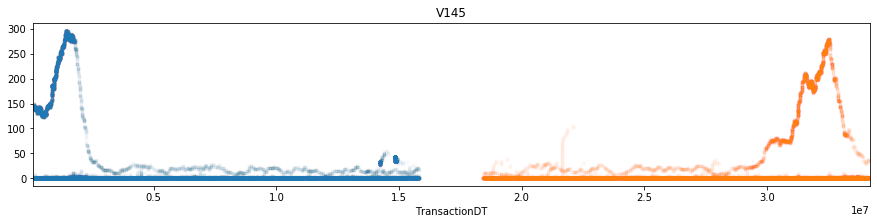

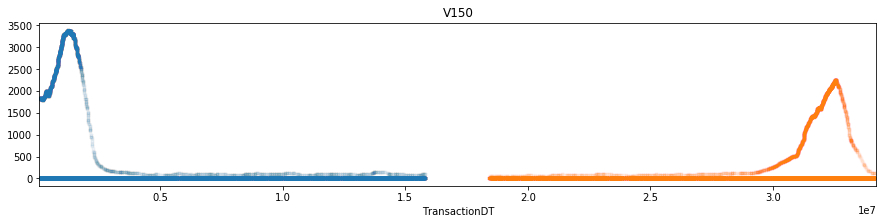

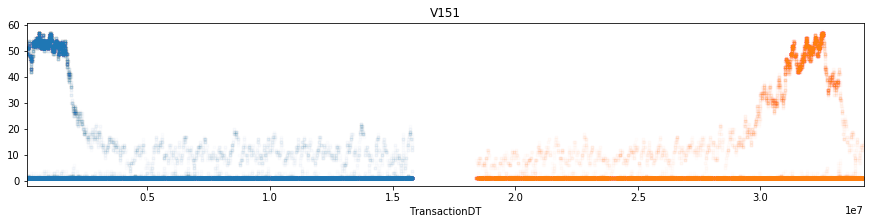

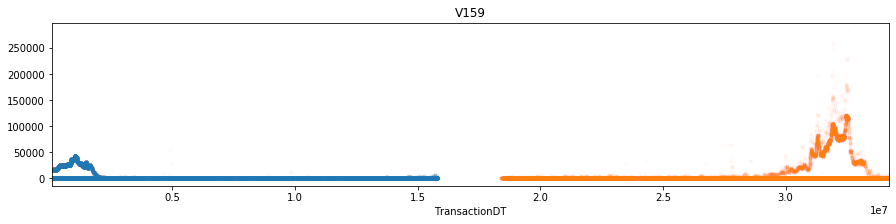

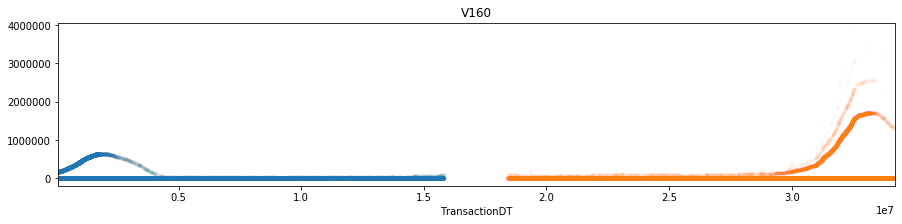

In [52]:
for c in ['V144','V145','V150','V151','V159','V160']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass

#### Number of unique valued per feature (V, train) - part 1 

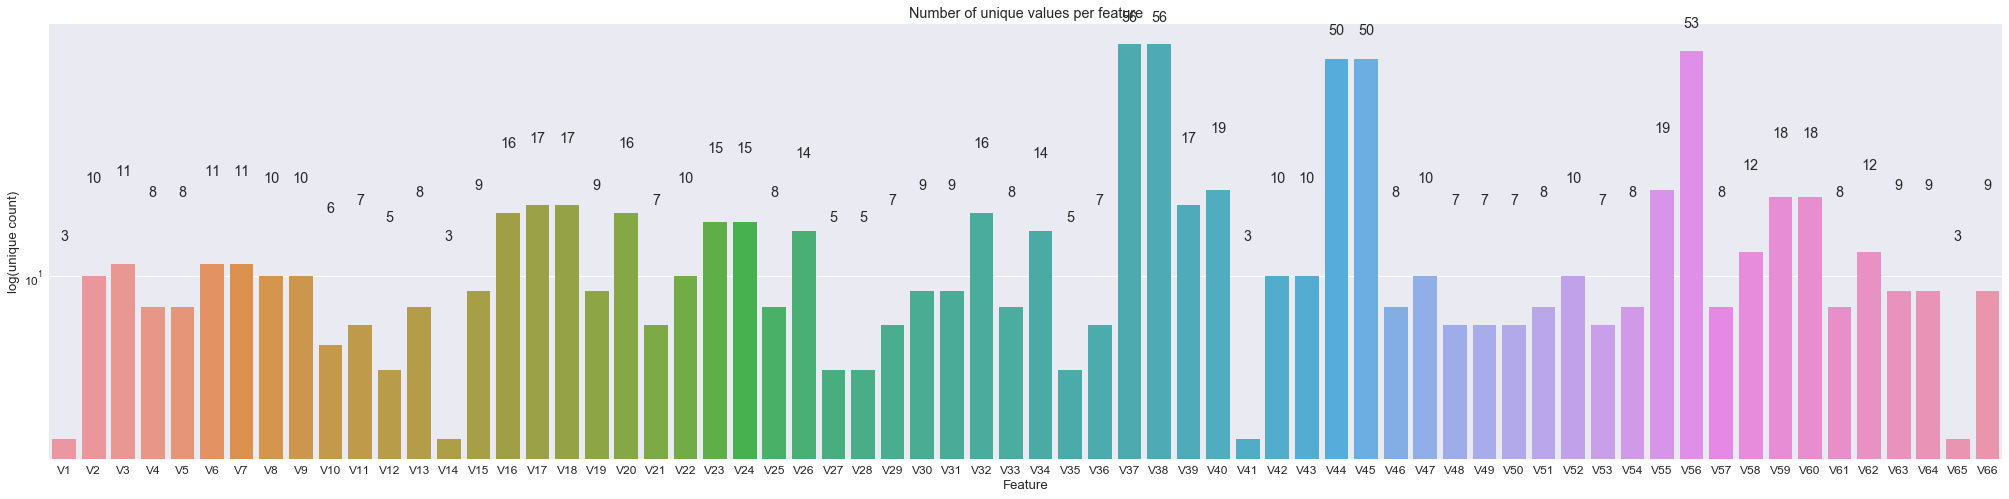

In [59]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[54:120])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

#### Number of unique valued per feature (V, train) - part 2

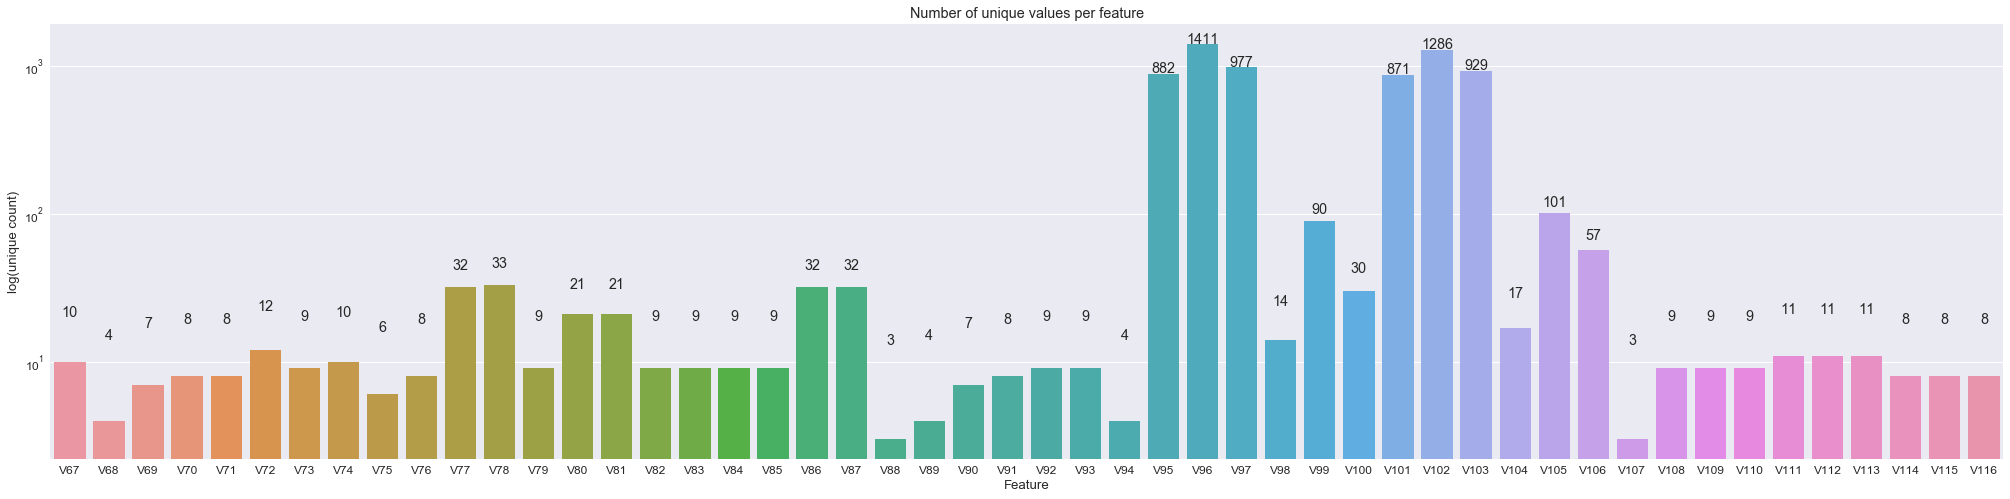

In [63]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[120:170])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

#### Number of unique valued per feature (V, train) - part 3

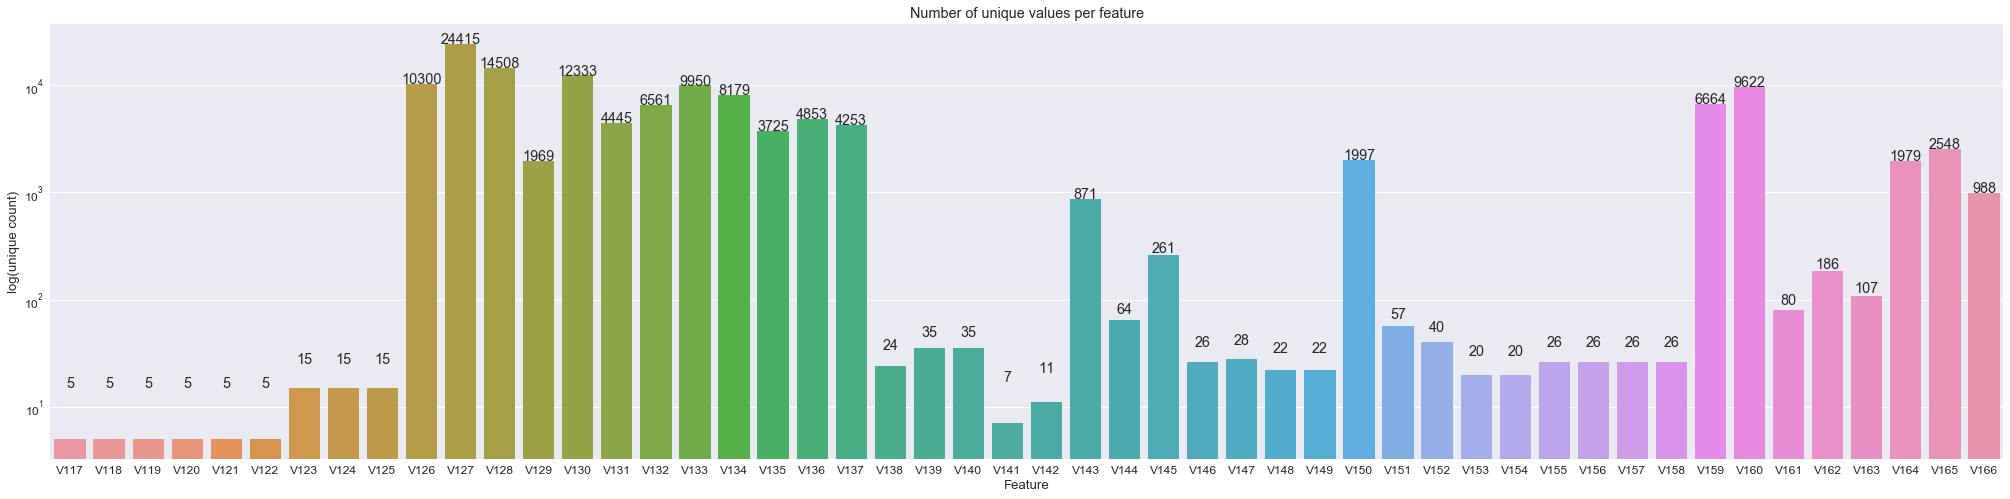

In [64]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[170:220])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

#### Number of unique valued per feature (V, train) - part 4

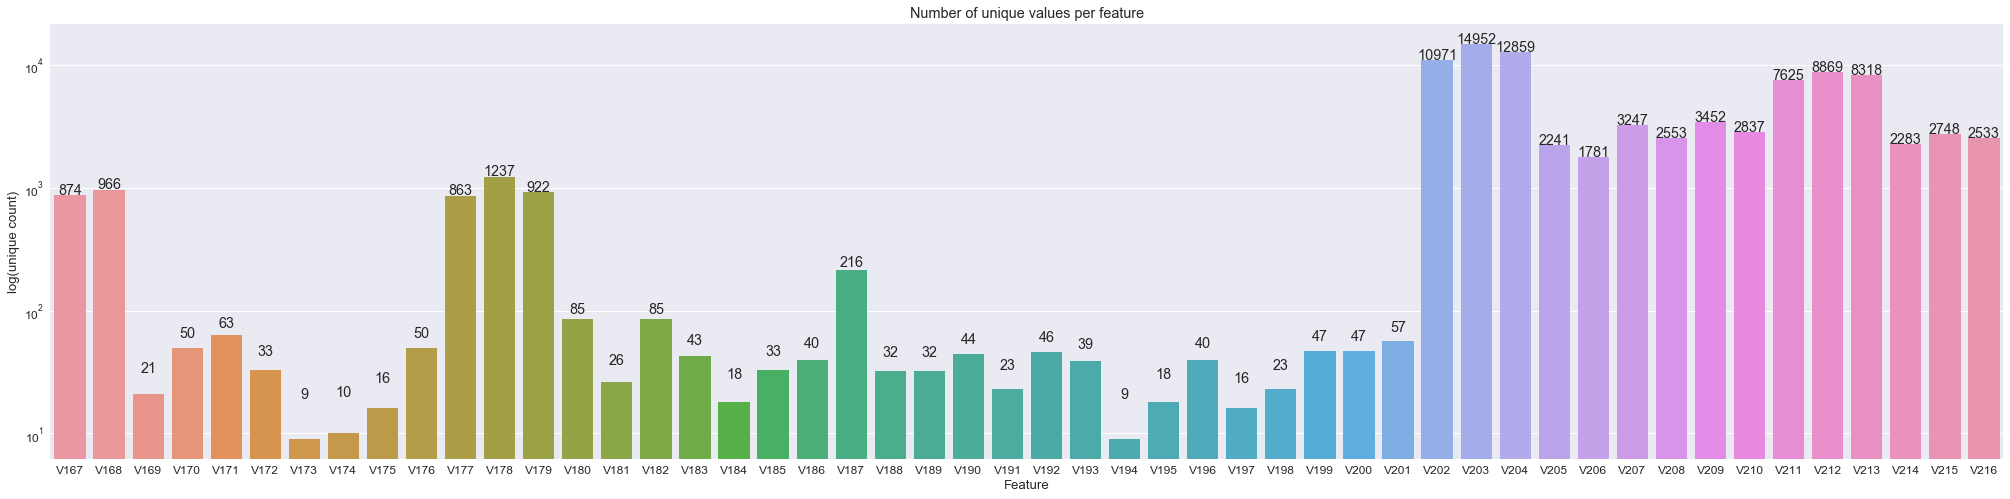

In [60]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[220:270])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

#### Number of unique valued per feature (V, train) - part 5

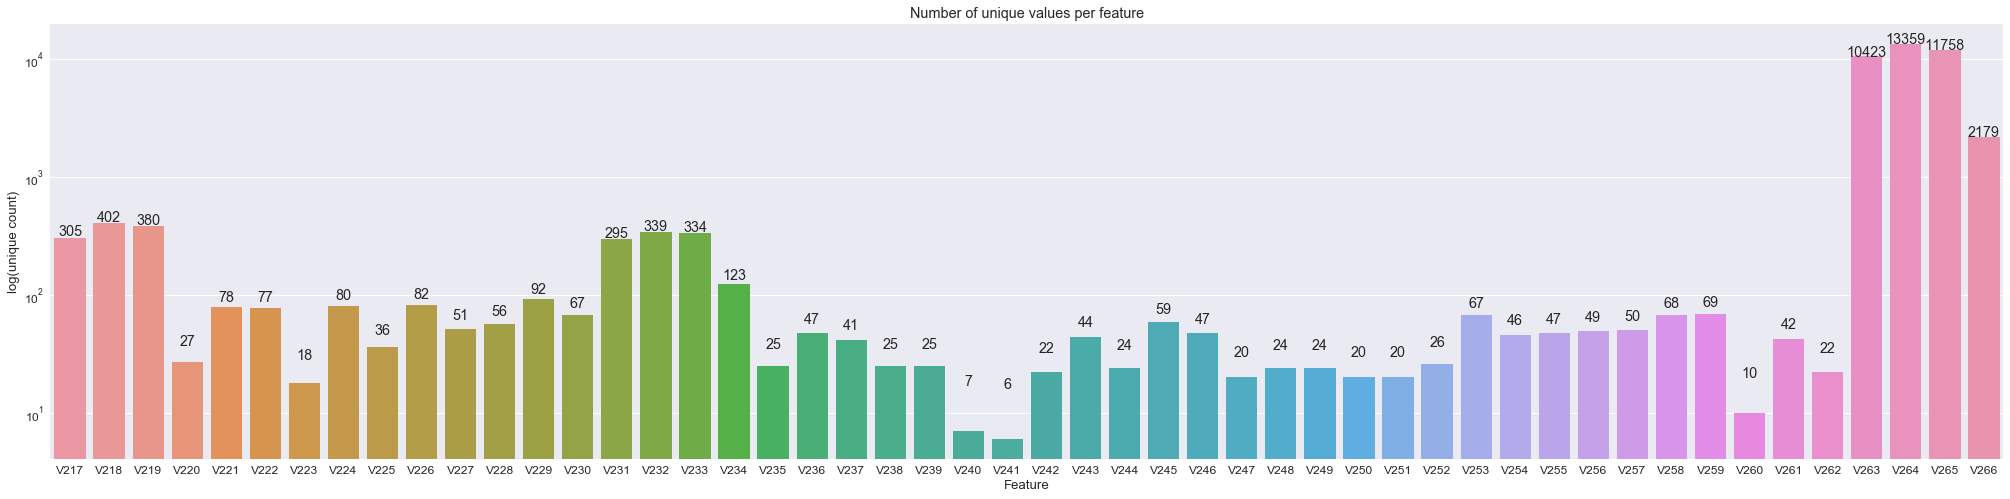

In [61]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[270:320])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

#### Number of unique valued per feature (V, train) - part 6

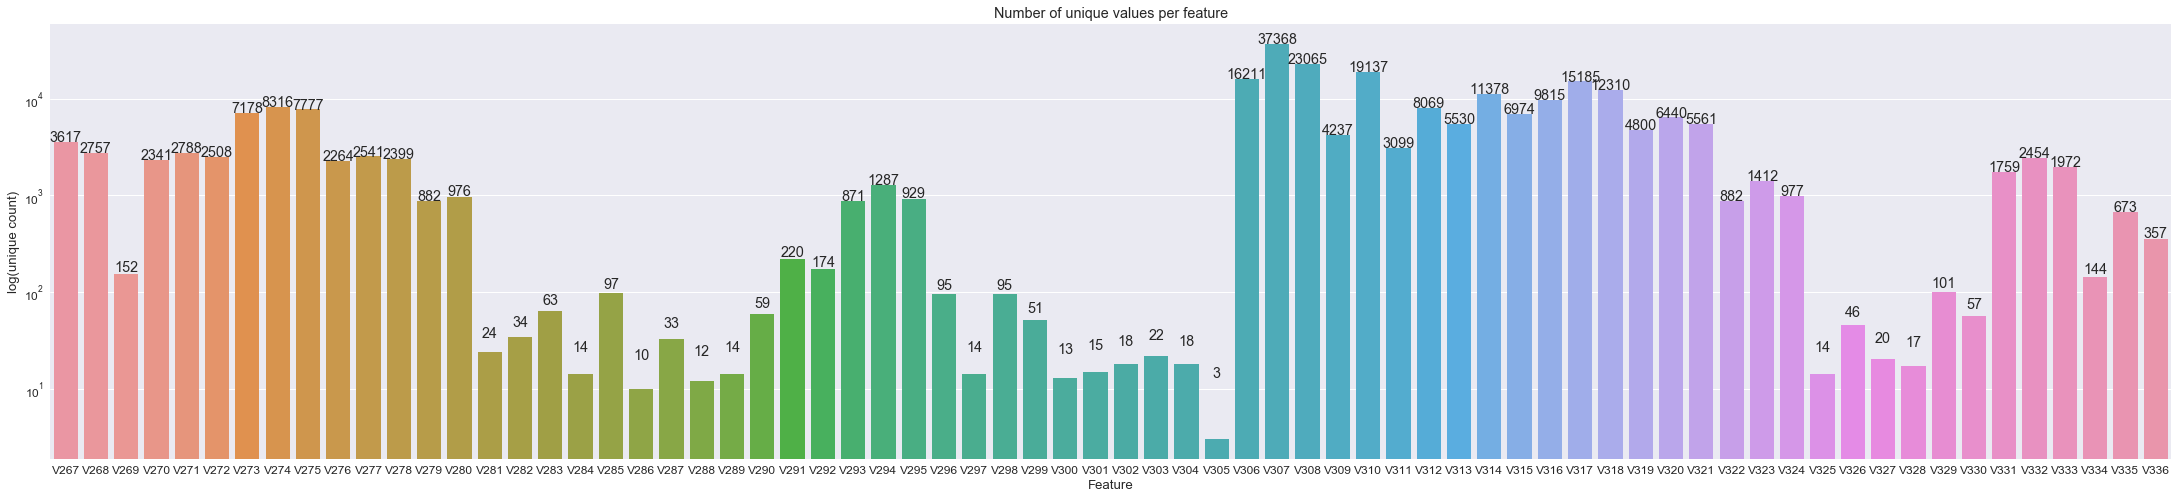

In [62]:
plt.figure(figsize=(38, 8))
v_features = list(train_transaction.columns[320:390])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Thoughts: Should we drop column by similarities in counts? 

###  Thoughts: Should time-based features be dropped?

In [ ]:
V feature: time since..? 